# Tensil Pynq Driver and Libraries

In [33]:
import sys
sys.path.append('/home/xilinx')

# Needed to run inference on TCU
import time
import numpy as np
import pynq
from pynq import Overlay
from tcu_pynq.driver import Driver
from tcu_pynq.architecture import pynqz1

# Needed for unpacking and displaying image data
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

# Path Check

In [42]:
!cd /home/xilinx
!ls

cifar-10-batches-py
jupyter_notebooks
jupyter_notebooks_2024_03_17_14_25_17
jupyter_notebooks_2024_03_17_14_28_02
jupyter_notebooks_2024_03_17_14_41_00
jupyter_notebooks_2024_03_17_14_43_44
libssl1.1_1.1.1-1ubuntu2.1~18.04.22_arm64.deb
pynq
resnet20v2_cifar_onnx_pynqz1.tdata
resnet20v2_cifar_onnx_pynqz1.tmodel
resnet20v2_cifar_onnx_pynqz1.tprog
REVISION
tcu_pynq
tensil_pynq2.bit
tensil_pynq2.hwh
tensil_pynqz1.bit
tensil_pynqz2.bit


# Overlay

Note: .bit and .hwh filenames must be the same. Bit file depending on FPGA and Tensil IP, not the model.

In [34]:
overlay = Overlay('/home/xilinx/tensil_pynq2.bit')

In [35]:
tcu = Driver(pynqz1, overlay.axi_dma_0)

# Model

In [38]:
tcu.load_model('/home/xilinx/resnet20v2_cifar_onnx_pynqz1.tmodel')

# Dataset

In [36]:
def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

cifar = unpickle('/home/xilinx/cifar-10-batches-py/test_batch')
data = cifar[b'data']
labels = cifar[b'labels']

data = data[10:20]
labels = labels[10:20]

data_norm = data.astype('float32') / 255
data_mean = np.mean(data_norm, axis=0)
data_norm -= data_mean

cifar_meta = unpickle('/home/xilinx/cifar-10-batches-py/batches.meta')
label_names = [b.decode() for b in cifar_meta[b'label_names']]

def show_img(data, n):
    plt.imshow(np.transpose(data[n].reshape((3, 32, 32)), axes=[1, 2, 0]))

def get_img(data, n):
    img = np.transpose(data_norm[n].reshape((3, 32, 32)), axes=[1, 2, 0])
    img = np.pad(img, [(0, 0), (0, 0), (0, tcu.arch.array_size - 3)], 'constant', constant_values=0)
    return img.reshape((-1, tcu.arch.array_size))

def get_label(labels, label_names, n):
    label_idx = labels[n]
    name = label_names[label_idx]
    return (label_idx, name)


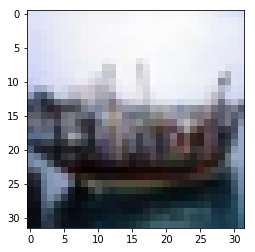

In [37]:
n = 8
img = get_img(data, n)
label_idx, label = get_label(labels, label_names, n)
show_img(data, n)


# Inference

In [39]:
inputs = {'x:0': img}

start = time.time()
outputs = tcu.run(inputs)
end = time.time()
print("Ran inference in {:.4}s".format(end - start))
print()

classes = outputs['Identity:0'][:10]
result_idx = np.argmax(classes)
result = label_names[result_idx]
print("Output activations:")
print(classes)
print()
print("Result: {} (idx = {})".format(result, result_idx))
print("Actual: {} (idx = {})".format(label, label_idx))


Ran inference in 0.1831s

Output activations:
[ -1.03125     -5.3984375   -6.25        -9.0078125  -10.7734375
 -13.140625     1.4140625  -13.48046875   5.84765625  -4.671875  ]

Result: ship (idx = 8)
Actual: ship (idx = 8)
